# Analysis of performance on the BioCreative V evaluation dataset

Tong Shu Li<br>
Created on: 2015-10-06<br>
Last updated: 2015-10-29

Now that the gold standard for the final evaluation dataset has been released, we can perform a more detailed analysis of our results and see where we went wrong.

In [1]:
from collections import defaultdict
from itertools import groupby
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.lingpipe.file_util import read_file
from src.lingpipe.file_util import save_file

from src.eval_perf import performance

from src.data_model import *
from src.F_score import F_score
from src.mesh_filter import filter_relations

In [5]:
from src.eval_perf import official_F_score

---

### First we need to de-anonymize the paper identifiers

In [6]:
def read_orig_ids(fname):
    title = dict()
    for line in read_file(fname):
        vals = line.split("|")
        if len(vals) == 3 and vals[1] == "t":
            title[vals[2]] = int(vals[0])
            
    return title

In [7]:
fname = os.path.abspath(os.path.join("..", "data", "final_eval", "orig_data", "CDR_TestSet.txt"))
masked_titles = read_orig_ids(fname)

fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
real_titles = read_orig_ids(fname)

In [8]:
assert masked_titles.keys() == real_titles.keys()

In [9]:
paper_mapping = {masked_titles[title] : real_titles[title] for title in real_titles.keys()}
save_file("testset_mapping.pickle", paper_mapping)

---

### Read the gold standard

In [10]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development", "test"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    save_loc = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))
    
    fname = "CDR_{0}Set.txt".format(dataset.capitalize())
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard"))
    
    return parse_file(save_loc, loc = loc, fname = fname,
        is_gold = True, return_format = file_format, fix_acronyms = False)

In [11]:
eval_gold = read_gold_standard("test", file_format = "dict")

### Read the original NER output

In [12]:
save_loc = loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_testset.pickle"))
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_all_relations.txt"))
testset = parse_file(save_loc, loc = loc, fname = "CDR_TestSet.txt",
                    is_gold = False, return_format = "dict", fix_acronyms = False)

In [13]:
def remap(papers):
    res = dict()
    for uid, paper in papers.items():
        paper.pmid = paper_mapping[uid]
        res[paper_mapping[uid]] = paper
        
    return res

In [14]:
if 0 in set(testset.keys()):
    testset = remap(testset)
    save_file(save_loc, testset)

---

### Read the crowd results

In [15]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "abstract_relation_res.tsv"))

abs_res = pd.read_csv(loc, sep = '\t')
abs_res = abs_res.rename(columns = {"percent_agree": "norm_conf_score"})

In [16]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "sentence_relation_abs_res.tsv"))
sent_res = pd.read_csv(loc, sep = '\t')

sent_res = sent_res.rename(columns = {"conf_score": "norm_conf_score",
                                      "score_vote_max": "num_votes"})

In [17]:
abs_res.loc[:, "pmid"] = abs_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

In [18]:
sent_res.loc[:, "pmid"] = sent_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

In [19]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,norm_conf_score,pmid,unit_id,chemical_id,disease_id
0,bcv_final_eval_hard_0,yes_direct,0.8182,1,0.198438,8701013,773935948,MESH:D006632,MESH:D003693
1,bcv_final_eval_hard_1,yes_direct,0.0000,0,0.000000,439781,773935949,MESH:D000809,MESH:D007022
2,bcv_final_eval_hard_10,yes_direct,0.0000,0,0.000000,23666265,773935958,MESH:D013498,MESH:D003556
3,bcv_final_eval_hard_100,yes_direct,0.0000,0,0.000000,24114426,773936048,MESH:D000431,MESH:D012893
4,bcv_final_eval_hard_1000,yes_direct,0.0000,0,0.000000,3155884,773936948,MESH:D004837,MESH:D009202


In [20]:
sent_res.head()

,chemical_id,norm_conf_score,disease_id,pmid,num_votes,sentence_ids,uniq_ids,unit_ids
0,MESH:D006632,0.000000,MESH:D014456,8701013,0,0_1,bcv_final_eval_easy_1,773931696
1,MESH:D015738,1.000000,MESH:D003693,8701013,5,0_0|0_2|0_3,bcv_final_eval_easy_0|bcv_final_eval_easy_3|bc...,773931695|773931698|773931699
2,MESH:D015738,0.000000,MESH:D014456,8701013,0,0_1,bcv_final_eval_easy_2,773931697
3,MESH:D012964,0.189597,MESH:D007022,439781,1,1_0,bcv_final_eval_easy_5,773931700
4,MESH:D000305,0.802824,MESH:D007674,22836123,4,2_4,bcv_final_eval_easy_10,773931705


In [21]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "cid_relations.pickle"))
cid_rels = save_file(loc)

cid_rels = {paper_mapping[pmid] : rels for pmid, rels in cid_rels.items()}

## Combine all results together

In [22]:
def flat_repr(id_set):
    vals = ["{0}:{1}".format(v.uid_type, v.uid) for v in id_set]
    return "|".join(sorted(vals))

In [23]:
def merge_results():
    temp = []    
    cols = ["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]
    
    sub = abs_res.loc[:, cols]
    sub.loc[:, "rel_origin"] = "abstract_task"
    temp.append(sub)

    sub = sent_res.loc[:, cols]
    sub.loc[:, "rel_origin"] = "sentence_task"
    temp.append(sub)
    
    things = defaultdict(list)
    for pmid, rels in cid_rels.items():
        for cid_relation in rels:
            things["pmid"].append(pmid)
            things["chemical_id"].append(flat_repr(cid_relation[0]))
            things["disease_id"].append(flat_repr(cid_relation[1]))
            
    things = pd.DataFrame(things)
    things.loc[:, "norm_conf_score"] = 1
    things.loc[:, "num_votes"] = 5
    things.loc[:, "rel_origin"] = "cid_relation"
    temp.append(things)
    
    return pd.concat(temp).sort(["pmid", "num_votes", "rel_origin",
                                "chemical_id", "disease_id"]).reset_index(drop = True)

In [24]:
final_results = merge_results()

In [25]:
final_results.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:C009695,MESH:D000699,0.000000,0,35781,sentence_task
1,MESH:C009695,MESH:D002375,0.000000,0,35781,sentence_task
2,MESH:D003000,MESH:D000699,0.000000,0,35781,sentence_task
3,MESH:D009278,MESH:D002375,0.000000,0,35781,sentence_task
4,MESH:D009638,MESH:D000699,0.185347,1,35781,abstract_task


In [26]:
final_results.shape

(4920, 6)

In [27]:
save_file("testset_final_res.pickle", final_results)

In [28]:
# change 6 votes to 5 votes for the purposes of evaluation
final_results.loc[:, "num_votes"] = final_results.num_votes.map(
    lambda v: 5 if v > 5 else v
)

In [29]:
final_results["num_votes"].value_counts()

0    1664
1     999
5     766
2     624
4     445
3     422
dtype: int64

---

## Performance

In [28]:
def parse_annots(papers):
    ans = set()
    for pmid, paper in papers.items():
        for annot in paper.annotations:
            ans.add((pmid, annot))
            
    return ans

### NER performance by tmChem and DNorm

In [29]:
predict = parse_annots(testset)
performance(parse_annots(eval_gold), predict, human_readable = True)

# True pos: 7684
# False pos: 1645
# False neg: 2125
Precision: 0.8236681316325437
Recall: 0.7833622183708839
F-score: 0.803009718883896


F-score on the NER is only 0.803, which is good but not terribly great. Not bad for an out of the box configuration though.

### CID relation performance

In [30]:
def official_F_score(score_column, gold_rel_set, dataframe, apply_mesh_filter = False):
    def apply_filter(predict):
        # filter using mesh ontology
        res = set()
        
        # group by pmid
        temp = sorted(list(predict), key = lambda val: val[0])
        for pmid, group in groupby(temp, lambda val: val[0]):            
            rels = [Simple_Rel(pmid, Ontology_ID(chem), Ontology_ID(dise)) for info, chem, dise in group]
            filtered = filter_relations(rels)
            filtered = [(rel.pmid, rel.chemical.flat_repr, rel.disease.flat_repr) for rel in filtered]
            
            res |= set(filtered)
            
        return res
    
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        # grab the relation ids we guessed
        predict = set(sub[["pmid", "chemical_id", "disease_id"]].apply(
                lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]), axis = 1))
        
        if apply_mesh_filter:
            predict = apply_filter(predict)
        
        precision, recall, f1 = performance(gold_rel_set, predict)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f1)
        
    return pd.DataFrame(res)

In [31]:
def simple_repr(id_set):
    assert len(id_set) == 1
    return list(id_set)[0].flat_repr

def get_gold_rels(gold_std):
    res = set()
    for pmid, paper in gold_std.items():
        for rel in paper.gold_relations:
            res.add((int(pmid), simple_repr(rel.chemical_id), simple_repr(rel.disease_id)))
            
    return res

In [32]:
gold_relations = get_gold_rels(eval_gold)

In [33]:
len(gold_relations)

1066

In [34]:
official_res = official_F_score("num_votes", gold_relations, final_results, apply_mesh_filter = False).sort("threshold")

In [35]:
official_res

,F_score,precision,recall,threshold
0,0.267624,0.162805,0.751407,0
1,0.356317,0.236486,0.722326,1
2,0.444779,0.327426,0.693246,2
3,0.496480,0.410288,0.628518,3
4,0.505929,0.475640,0.540338,4
5,0.465066,0.556136,0.399625,5
6,0.003742,0.666667,0.001876,6


These results exactly match what Yifan sent us for the official evaluations. This is good, because it means that I reproduced things correctly.

In [36]:
def plot_results(res, title, xlabel, fontsize, figsize, linewidth, fname = None):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = linewidth, title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

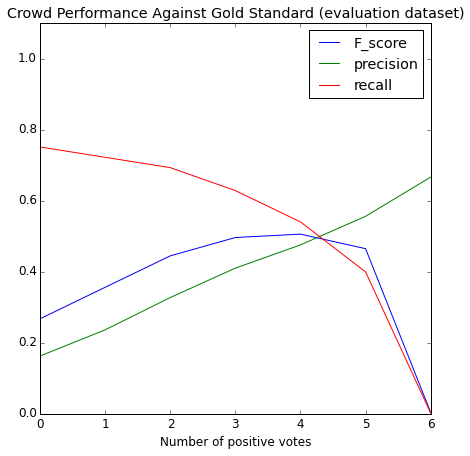

In [37]:
plot_results(official_res, "Crowd Performance Against Gold Standard (evaluation dataset)",
            "Number of positive votes", 12, (7, 7), 1)

### Performance with MeSH filtering

In [38]:
filtered_res = official_F_score("num_votes", gold_relations, final_results, apply_mesh_filter = True).sort("threshold")

In [39]:
filtered_res

,F_score,precision,recall,threshold
0,0.290285,0.182678,0.706379,0
1,0.375514,0.258682,0.684803,1
2,0.460281,0.353236,0.660413,2
3,0.509680,0.440273,0.605066,3
4,0.514049,0.504977,0.523452,4
5,0.464907,0.579021,0.388368,5
6,0.003742,0.666667,0.001876,6


In [40]:
def pair_plot(df1, df2, title, xlabel, fontsize, figsize, linewidth, fname = None):
    matplotlib.rcParams.update({"font.size": fontsize})

    ax = df1.plot(x = "threshold", figsize = figsize,
                  title = title, ylim = (0, 1.05), linewidth = linewidth)

    ax = df2.plot(ax = ax, x = "threshold", linestyle = "--", linewidth = linewidth)
    ax.set_xlabel(xlabel)

    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

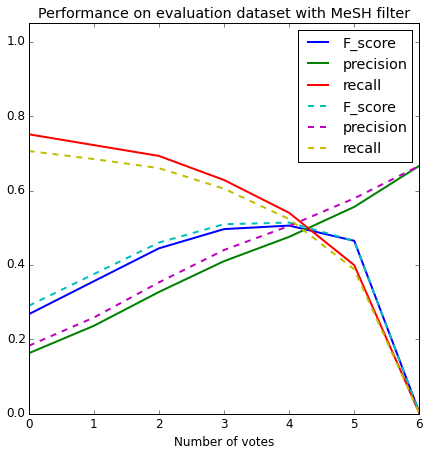

In [41]:
pair_plot(official_res, filtered_res, "Performance on evaluation dataset with MeSH filter",
          "Number of votes", 12, (7, 7), 2)

---

### Performance with NER mistakes filtered out

In [42]:
def has_concept(paper, concept_id):
    concepts = set()
    for annot in paper.annotations:
        concepts |= set([iden.flat_repr for iden in annot.uid if iden.uid_type == "MESH"])
    
    return concept_id in concepts

In [43]:
final_results["chem_exists"] = final_results[["pmid", "chemical_id"]].apply(lambda row: has_concept(eval_gold[int(row["pmid"])], row["chemical_id"]), axis = 1)

final_results["dise_exists"] = final_results[["pmid", "disease_id"]].apply(lambda row: has_concept(eval_gold[int(row["pmid"])], row["disease_id"]), axis = 1)

In [44]:
final_results.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,chem_exists,dise_exists
0,MESH:C009695,MESH:D000699,0.000000,0,35781,sentence_task,True,False
1,MESH:C009695,MESH:D002375,0.000000,0,35781,sentence_task,True,True
2,MESH:D003000,MESH:D000699,0.000000,0,35781,sentence_task,True,False
3,MESH:D009278,MESH:D002375,0.000000,0,35781,sentence_task,True,True
4,MESH:D009638,MESH:D000699,0.185347,1,35781,abstract_task,True,False


In [45]:
final_results["chem_exists"].value_counts()

True     4787
False     133
dtype: int64

In [46]:
final_results["dise_exists"].value_counts()

True     4029
False     891
dtype: int64

In [47]:
def filter_gold(gold_rels, dataframe):
    concepts = defaultdict(set)
    for pmid, group in dataframe.groupby("pmid"):
        concepts[pmid] |= set(group["chemical_id"]) | set(group["disease_id"])
        
    res = set()
    for pmid, chem, dise in gold_rels:
        if set([chem, dise]) <= concepts[pmid]:
            res.add((pmid, chem, dise))
            
    return res

In [48]:
indexable = final_results.query("chem_exists and dise_exists")
common_gold = filter_gold(gold_relations, indexable)

In [49]:
len(common_gold)

801

In [50]:
no_ner_res = official_F_score("num_votes", common_gold, indexable).sort("threshold")

In [51]:
no_ner_res

,F_score,precision,recall,threshold
0,0.339551,0.204493,1.000000,0
1,0.447935,0.291998,0.961298,1
2,0.554181,0.396034,0.922597,2
3,0.618366,0.490483,0.836454,3
5,0.631579,0.563050,0.719101,4
4,0.581570,0.641566,0.531835,5
6,0.004975,0.666667,0.002497,6


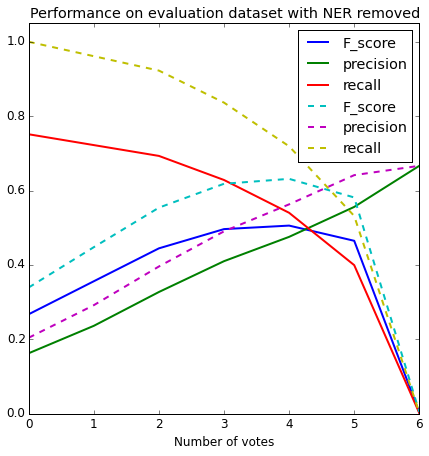

In [52]:
pair_plot(official_res, no_ner_res, "Performance on evaluation dataset with NER removed",
          "Number of votes", 12, (7, 7), 2)

In [53]:
no_ner_filtered = official_F_score("num_votes", common_gold, indexable, True).sort("threshold")

In [54]:
no_ner_filtered

,F_score,precision,recall,threshold
0,0.362122,0.223692,0.950062,0
1,0.465588,0.312075,0.916355,1
2,0.567535,0.417946,0.883895,2
3,0.630709,0.516309,0.810237,3
5,0.635588,0.583507,0.697878,4
4,0.580014,0.658730,0.518102,5
6,0.004975,0.666667,0.002497,6


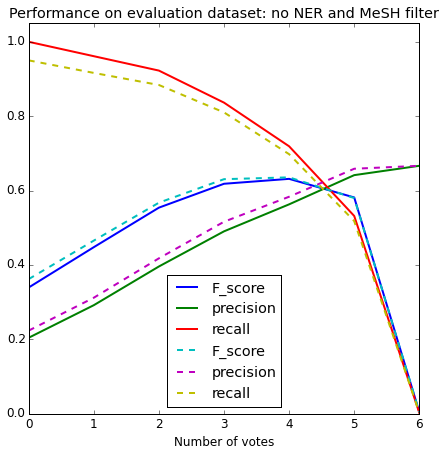

In [55]:
pair_plot(no_ner_res, no_ner_filtered, "Performance on evaluation dataset: no NER and MeSH filter",
          "Number of votes", 12, (7, 7), 2)

Based on these data we see that the crowd behaves almost exactly like our experiment with the 100 abstracts. The MeSH filtering as currently implemented makes almost no difference in terms of F-score, especially if we remove problems with NER. The different is slightly larger when applied normally.

When we remove NER related errors, we see that our result on 500 unseen abstracts was almost exactly the same as our results for the 100 abstracts from the development set. Without a sense of what the expert inter-annotator agreement looks like, it is difficult to say what the upper bound on performance is. A detailed manual error analysis is now necessary to determine where we went wrong.

---

## Manual error analysis

We now look at the errors which occur post-NER and MeSH filtering and try to determine how these errors arose.

In [56]:
indexable["rel_origin"].value_counts(normalize = True)

abstract_task    0.544294
sentence_task    0.410263
cid_relation     0.045443
dtype: float64

It seems that most of the positive CID relations came from the sentence tasks. Let's look at those first.

### Create an easy to edit spreadsheet of the sentence relations

In [57]:
sent_rel = indexable.query("rel_origin == 'sentence_task'")

In [58]:
p = sent_rel[["pmid", "chemical_id", "disease_id", "num_votes", "rel_origin"]]
q = sent_res[["pmid", "chemical_id", "disease_id", "unit_ids"]]

result = pd.merge(p, q, how = "inner", on = ["pmid", "chemical_id", "disease_id"])

In [59]:
def check(row):
    return int((row["pmid"], row["chemical_id"], row["disease_id"]) in gold_relations)

def grab_names(paper):
    name = defaultdict(set)
    for annot in paper.annotations:
        assert len(annot.uid) == 1
        name[annot.flat_repr].add(annot.text.lower())
        
    return {uid : "|".join(vals) for uid, vals in name.items()}


names = dict()
for pmid, paper in testset.items():
    names[pmid] = grab_names(paper)
   
result.loc[:, "in_gold"] = result[["pmid", "chemical_id", "disease_id"]].apply(check, axis = 1)

result.loc[:, "chemical_name"] = result[["pmid", "chemical_id"]].apply(lambda row: names[row["pmid"]][row["chemical_id"]], axis = 1)
result.loc[:, "disease_name"] = result[["pmid", "disease_id"]].apply(lambda row: names[row["pmid"]][row["disease_id"]], axis = 1)

result.loc[:, "crowd_right"] = np.nan
result.loc[:, "conclusion"] = np.nan
result.loc[:, "description"] = np.nan

In [60]:
result.head()

,pmid,chemical_id,disease_id,num_votes,rel_origin,unit_ids,in_gold,chemical_name,disease_name,crowd_right,conclusion,description
0,35781,MESH:C009695,MESH:D002375,0,sentence_task,773932408,1,xylometazoline,catalepsy,NaN,NaN,NaN
1,35781,MESH:D009278,MESH:D002375,0,sentence_task,773932407,1,naphazoline,catalepsy,NaN,NaN,NaN
2,35781,MESH:D003061,MESH:D002375,2,sentence_task,773932406,1,codeine,catalepsy,NaN,NaN,NaN
3,35781,MESH:D009020,MESH:D002375,3,sentence_task,773932405,1,morphine,catalepsy,NaN,NaN,NaN
4,35781,MESH:D003000,MESH:D002375,5,sentence_task,773932409,1,clonidine,catalepsy,NaN,NaN,NaN


Now that we have a comprehensive dataframe, we can look at the false positives and false negatives separately.

---

### Sentence-task false positives

In [61]:
false_pos = result.query("num_votes >= 4 and in_gold == 0")

In [62]:
false_pos.shape

(246, 12)

In [63]:
false_pos.head()

,pmid,chemical_id,disease_id,num_votes,rel_origin,unit_ids,in_gold,chemical_name,disease_name,crowd_right,conclusion,description
12,146391,MESH:D010672,MESH:D005076,5,sentence_task,773932416|773932418|773932422,0,diphenylhydantoin,skin rash,NaN,NaN,NaN
29,448423,MESH:D000614,MESH:D013345,4,sentence_task,773932432,0,aminocaproic acid,subarachnoid hemorrhage|sah,NaN,NaN,NaN
37,611664,MESH:D009638,MESH:D004342,5,sentence_task,773932452,0,norepinephrine,hypersensitivity,NaN,NaN,NaN
43,733189,MESH:D010406,MESH:D001766,4,sentence_task,773932459,0,penicillin,blindness,NaN,NaN,NaN
55,891494,MESH:D010672,MESH:D012640,5,sentence_task,773932475|773932478,0,phenytoin|dph,seizures,NaN,NaN,NaN


Since 250 relations is too many to verify by hand, we will take a random sample of the results.

In [64]:
rand_key = np.random.RandomState(20151007)

In [65]:
fp_sample = false_pos.sample(n = 50, random_state = rand_key)

In [66]:
fp_sample.shape

(50, 12)

In [67]:
fp_sample

,pmid,chemical_id,disease_id,num_votes,rel_origin,unit_ids,in_gold,chemical_name,disease_name,crowd_right,conclusion,description
177,2553470,MESH:D010862,MESH:D012640,4,sentence_task,773932660|773932664|773932667|773932671|773932675,0,pilocarpine,seizure|seizures,NaN,NaN,NaN
432,7248895,MESH:D003520,MESH:D003556,5,sentence_task,773932328,0,cyclophosphamide,hemorrhagic cystitis,NaN,NaN,NaN
871,15096374,MESH:D013256,MESH:D012393,4,sentence_task,773933891,0,steroid,rosacea,NaN,NaN,NaN
959,16801510,MESH:D011188,MESH:D008133,4,sentence_task,773934061,0,potassium,long qt syndrome|qt prolongation|qtc prolongation,NaN,NaN,NaN
639,9725303,MESH:D019469,MESH:D052878,4,sentence_task,773933469,0,indinavir,urolithiasis,NaN,NaN,NaN
755,11425091,MESH:D003042,MESH:D006470,5,sentence_task,773933691,0,cocaine,subependymal hemorrhage,NaN,NaN,NaN
901,15627798,MESH:D005839,MESH:D005355,4,sentence_task,773933949,0,gentamicin,fibrosis,NaN,NaN,NaN
258,3289726,MESH:D005047,MESH:D064420,4,sentence_task,773932805,0,vp-16-213|etoposide,toxicity,NaN,NaN,NaN
1177,19681452,MESH:D003042,MESH:D001145,5,sentence_task,773932376,0,cocaine,cardiac arrhythmia,NaN,NaN,NaN
512,8308951,MESH:D010894,MESH:D001778,5,sentence_task,773933245,0,piroxicam,coagulopathy,NaN,NaN,NaN


In [68]:
fp_sample.to_csv("evalset_false_pos_sample.tsv", sep = '\t', index = False)

### Example of missing sentence relation

MESH:D010672	1	MESH:D005076	146391	5	124_1|124_3|124_6	bcv_final_eval_easy_721|bcv_final_eval_easy_72...	773932416|773932418|773932422